In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import textwrap

import shap

In [2]:
data = np.load('../processed_ntuples/transverse_helicity/chunk_wnu_data.npy')
np.shape(data)

(527375, 38)

In [3]:
train, val = train_test_split(data, random_state=137) # setting the seed for reproducibility; the default train/test split is 0.75/0.25
print('lenght of training set', len(train), '\nlenght of validation set', len(val), '\nwidth of the sets: # of features + 1 flag (1-LL/0-TX)', len(train[0]))

lenght of training set 395531 
lenght of validation set 131844 
width of the sets: # of features + 1 flag (1-LL/0-TX) 38


In [4]:
# strip the last feature (e.g. the flag) from the sets

# first line check
print('first train line, before flag-stripping', train[0])

# copy in dedicated arrays
flags_train = train[:, -1]
flags_val = val[:, -1]
# delete from the sets
train = train[:, :-1]
val = val[:, :-1]
# width check
print('width of the samples, after flag-stripping', len(train[0]), len(val[0]))
# first line check
print('first train line, after flag-stripping', train[0])

first train line, before flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -1.07793952 -2.49373044  1.04359678 -1.1872246   1.79323445 -0.01288755
 -1.31579649 -2.24224946  1.86085179 -0.55318785 -0.36724764  0.91230302
  0.03663595 -0.2697674   0.92358258 -1.12239482 -1.80520892 -1.0771277
 -1.10550845  1.77859855 -0.55486745 -1.46640027  0.02515023  0.11602841
 -1.06045198  0.98780102  1.08062931  0.54832254  0.24672216  0.56147322
  0.78072666  0.        ]
width of the samples, after flag-stripping 37 37
first train line, after flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -1.07793952 -2.49373044  1.04359678 -1.1872246   1.79323445 -0.01288755
 -1.31579649 -2.24224946  1.86085179 -0.55318785 -0.36724764  0.91230302
  0.03663595 -0.2697674   0.92358258 -1.12239482 -1.80520892 -1.0771277
 -1.10550845  1.77859855 -0.55486745 -1.46640027  0.02515023  0.11602841
 -1.06045198  0.98780102  1.08062931  0.54832

In [5]:
# tensorize the data, so that pytorch doesn't whine
train = torch.tensor(train, dtype=torch.float32)
val = torch.tensor(val, dtype=torch.float32)
flags_train = torch.tensor(flags_train, dtype=torch.float32)
flags_val = torch.tensor(flags_val, dtype=torch.float32)

In [6]:
# creation of the model class
# (don't know if the sigmoid is defined in the best way possibile; this one just works)
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.dense1 = nn.Linear(37, 64)
        self.BatchNorm1d1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.dense2 = nn.Linear(64, 48)
        self.BatchNorm1d2 = nn.BatchNorm1d(48)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.dense3 = nn.Linear(48, 32)
        self.BatchNorm1d3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.dense4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.dense1(x)
        x = self.BatchNorm1d1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.BatchNorm1d2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.BatchNorm1d3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.dense4(x)
        x = self.sigmoid(x)
        return x

In [7]:
model = torch.load('../ctcsthwnu-model.pt', weights_only=False)
#model.eval()

In [8]:
predict = lambda x: model(torch.autograd.Variable(torch.from_numpy(x))).detach().numpy()

In [9]:
data_size = 1000
data = val[0:data_size].detach().numpy()

features_names = ['lepPt1', 'lepPt2', 'lepEta1', 'lepEta2', 'lepPhi1', 'lepPhi2',
            'vbsjetPt1', 'vbsjetPt2', 'vbsjetEta1', 'vbsjetEta2', 'vbsjetPhi1',
            'vbsjetPhi2', 'vbsjetM1', 'vbsjetM2', 'nvbsjetPt1', 'nvbsjetPt2',
            'nvbsjetEta1', 'nvbsjetEta2', 'nvbsjetPhi1', 'nvbsjetPhi2', 'nvbsjetM1',
            'nvbsjetM2', 'mjj', 'detajj', 'ptMET', 'phiMET', 'ptv1', 'ptv2',
            'etav1', 'etav2', 'phiv1', 'phiv2', 'costheta1', 'costheta2', 'CScostheta',
            'cos_th_1', 'cos_th_2']

In [10]:
torch.set_grad_enabled(False)
explainer = shap.KernelExplainer(predict, data)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [11]:
# shap_values = explainer.shap_values(data)
# np.save('shapley_values/shap_values.npy', shap_values)
shap_values = np.load('shapley_values/shap_values.npy')

In [12]:
mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()

# Create a DataFrame for sorting
feature_importance = pd.DataFrame({
    'feature': features_names,
    'importance': mean_abs_shap
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

print(feature_importance)

        feature  importance
23       detajj    0.090566
22          mjj    0.088900
6     vbsjetPt1    0.077708
7     vbsjetPt2    0.063560
26         ptv1    0.030825
0        lepPt1    0.021546
24        ptMET    0.021205
9    vbsjetEta2    0.012248
27         ptv2    0.010824
14   nvbsjetPt1    0.009447
29        etav2    0.009174
28        etav1    0.008897
2       lepEta1    0.006999
32    costheta1    0.006133
8    vbsjetEta1    0.005795
5       lepPhi2    0.004825
35     cos_th_1    0.004177
1        lepPt2    0.003836
3       lepEta2    0.002698
33    costheta2    0.002462
30        phiv1    0.002317
36     cos_th_2    0.002128
34   CScostheta    0.001966
25       phiMET    0.001896
4       lepPhi1    0.001199
11   vbsjetPhi2    0.000520
15   nvbsjetPt2    0.000517
13     vbsjetM2    0.000483
20    nvbsjetM1    0.000443
17  nvbsjetEta2    0.000396
10   vbsjetPhi1    0.000371
19  nvbsjetPhi2    0.000302
12     vbsjetM1    0.000288
16  nvbsjetEta1    0.000246
18  nvbsjetPhi1    0

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:,0][0], features_names)

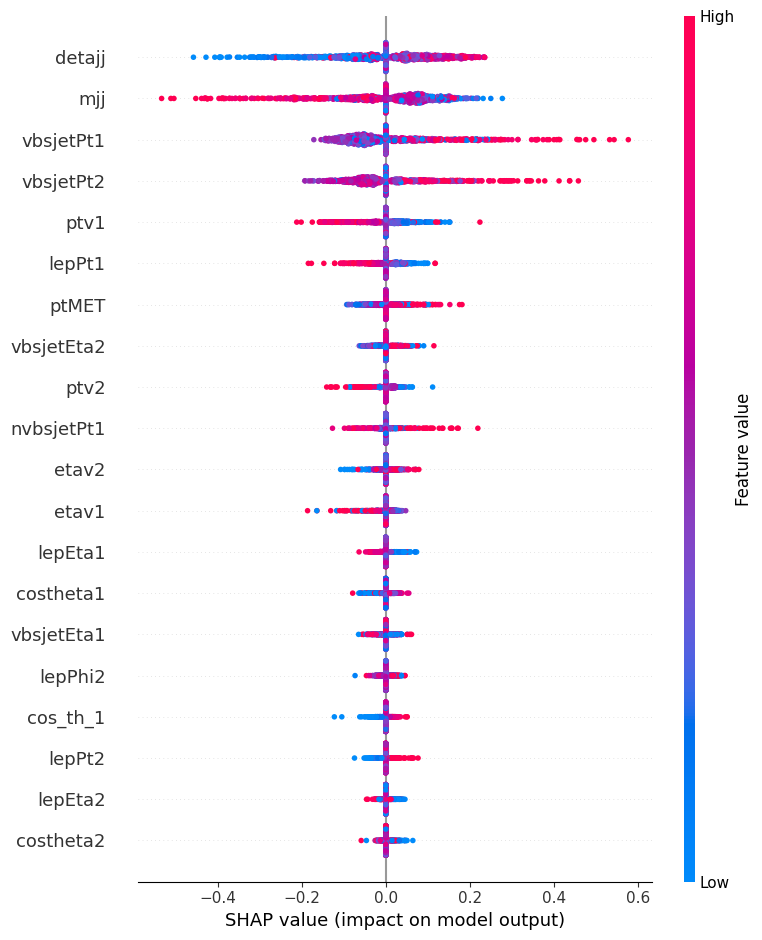

In [14]:
shap.summary_plot(shap_values[:,:,0], data, features_names)

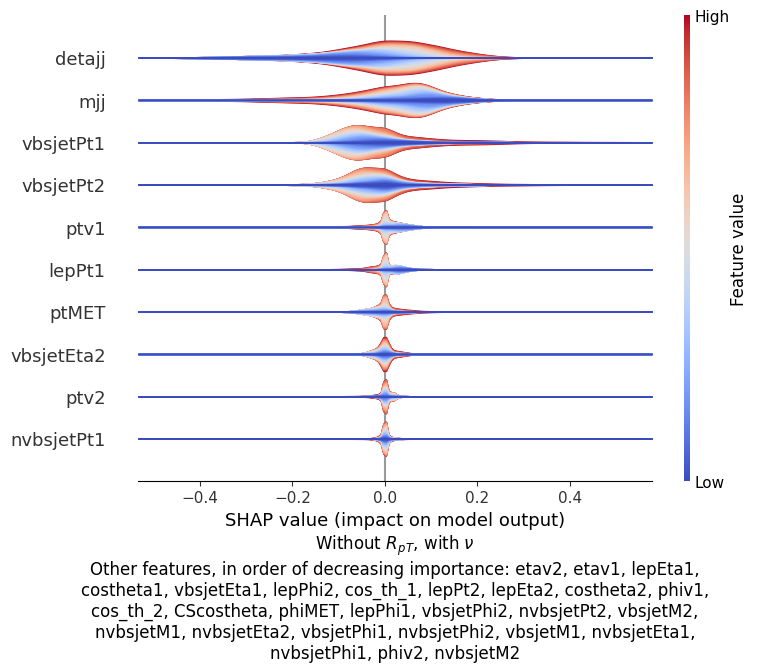

In [15]:
shap.summary_plot(shap_values[:,:,0], data, features_names, plot_type="layered_violin", max_display=10, show=False)
fig = plt.gcf()
fig.suptitle(f"Without $R_p$$_T$, with $\\nu$ \n"+'\n'.join(textwrap.wrap(f"Other features, in order of decreasing importance:\n{', '.join(feature_importance['feature'].to_numpy()[10:])}", width=int(fig.get_size_inches()[0] * 10))), y=0.02)
plt.savefig('figs/shap_norpt-wnu.png', dpi=500, bbox_inches='tight')

In [16]:
# # # DeepExplainer

# torch.set_grad_enabled(True)
# data = val[0:data_size]
# explainer = shap.DeepExplainer(model, data)

# shap_values = explainer.shap_values(data)

# print(np.shape(data), np.shape(shap_values[:,:,0]))

# shap.summary_plot(shap_values[:,:,0], data, features_names, plot_type="layered_violin")

In [17]:
#